# (TITLE OF THE PROJECT)
#### AIM - 
###### (LINKS)

In [33]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date and time
from datetime import datetime

# Preprocessing and modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Utilities
import warnings
warnings.filterwarnings("ignore")

In [34]:
# LOAD DATASETS
domain = pd.read_csv("data/domain_properties.csv")
suburb = pd.read_csv("data/syd_sub_rev.csv")

In [35]:
# CHECKING DATA
print("Domain Properties\n")
print(domain.info(), "\n\n", domain.head, "\n\n", domain.describe)
print("\n\nSydney Suburb Review\n")
print(suburb.info(), "\n\n", suburb.head, "\n\n", suburb.describe)

Domain Properties

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11160 entries, 0 to 11159
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   price                     11160 non-null  int64  
 1   date_sold                 11160 non-null  object 
 2   suburb                    11160 non-null  object 
 3   num_bath                  11160 non-null  int64  
 4   num_bed                   11160 non-null  int64  
 5   num_parking               11160 non-null  int64  
 6   property_size             11160 non-null  int64  
 7   type                      11160 non-null  object 
 8   suburb_population         11160 non-null  int64  
 9   suburb_median_income      11160 non-null  int64  
 10  suburb_sqkm               11160 non-null  float64
 11  suburb_lat                11160 non-null  float64
 12  suburb_lng                11160 non-null  float64
 13  suburb_elevation          11160 non-null  

In [36]:
# COLUMN STANDARDISATION
domain.columns = domain.columns.str.strip().str.lower().str.replace(" ", "_")
suburb.columns = suburb.columns.str.strip().str.lower().str.replace(" ", "_")

In [37]:
# CLEANING SUBURB FIRST
# RENAMING COLUMNS FOR LATER MERGING
suburb.rename(columns={"name" : "suburb"}, inplace=True)

# CHECK FOR DUPLICATE
print(suburb["suburb"].nunique(), "unique suburbs out of", suburb.shape[0], "rows")
print(suburb["suburb"].duplicated().sum(), "duplicate suburb entries")

421 unique suburbs out of 421 rows
0 duplicate suburb entries


In [38]:
# REMOVING SYMBOLS AND CONVERTING TYPES
def clean_currency(val):
    if isinstance(val, str):
        return pd.to_numeric(val.replace("$", "").replace(",", ""), errors="coerce")
    return val

def clean_percent(val):
    if isinstance(val, str):
        return pd.to_numeric(val.replace("%", ""), errors="coerce")
    return val

def clean_int(val):
    if isinstance(val, str):
        return pd.to_numeric(val.replace(",", ""), errors="coerce")
    return val

suburb["population_(rounded)*"] = suburb["population_(rounded)*"].apply(clean_int)
suburb["median_house_price_(2020)"] = suburb["median_house_price_(2020)"].apply(clean_currency)
suburb["median_house_price_(2021)"] = suburb["median_house_price_(2021)"].apply(clean_currency)
suburb["median_house_rent_(per_week)"] = suburb["median_house_rent_(per_week)"].apply(clean_currency)
suburb["median_apartment_price_(2020)"] = suburb["median_apartment_price_(2020)"].apply(clean_currency)
suburb["median_apartment_rent_(per_week)"] = suburb["median_apartment_rent_(per_week)"].apply(clean_currency)
suburb["%_change"] = suburb["%_change"].apply(clean_percent)
suburb["public_housing_%"] = suburb["public_housing_%"].apply(clean_percent)

In [39]:
currency_cols = [
    "median_house_price_(2020)", "median_house_price_(2021)",
    "median_apartment_price_(2020)", "median_house_rent_(per_week)",
    "median_apartment_rent_(per_week)"
]

percent_cols = ["%_change", "public_housing_%"]
int_cols = ["population_(rounded)*"]

for col in currency_cols:
    suburb[col] = suburb[col].apply(clean_currency)

for col in percent_cols:
    suburb[col] = suburb[col].apply(clean_percent)

for col in int_cols:
    suburb[col] = suburb[col].apply(clean_int)

suburb.dtypes

suburb                                            object
region                                            object
population_(rounded)*                              int64
postcode                                           int64
ethnic_breakdown_2016                             object
median_house_price_(2020)                        float64
median_house_price_(2021)                        float64
%_change                                         float64
median_house_rent_(per_week)                     float64
median_apartment_price_(2020)                    float64
median_apartment_rent_(per_week)                 float64
public_housing_%                                 float64
avg._years_held                                  float64
time_to_cbd_(public_transport)_[town_hall_st]     object
time_to_cbd_(driving)_[town_hall_st]              object
nearest_train_station                             object
highlights/attractions                            object
ideal_for                      

In [40]:
# DROPPING COLUMNS
suburb.drop(columns=[
    "region",
    "ethnic_breakdown_2016",
    "nearest_train_station",
    "highlights/attractions",
    "ideal_for",
    "review_link"
], inplace=True, errors="ignore")

for col in ["time_to_cbd_(public_transport)_[town_hall_st]", "time_to_cbd_(driving)_[town_hall_st]"]:
    suburb[col] = suburb[col].str.extract(r"(\d+)").astype(float)

In [41]:
# CHECKING FOR NULLS IN SUBURB
suburb.isnull().sum().sort_values(ascending=False), suburb.dtypes

(median_apartment_price_(2020)                    122
 median_apartment_rent_(per_week)                  71
 avg._years_held                                   51
 median_house_rent_(per_week)                      19
 median_house_price_(2021)                         15
 time_to_cbd_(public_transport)_[town_hall_st]      4
 %_change                                           4
 median_house_price_(2020)                          3
 time_to_cbd_(driving)_[town_hall_st]               2
 traffic                                            2
 public_housing_%                                   2
 noise                                              1
 affordability_(buying)                             1
 nature                                             1
 public_transport                                   1
 affordability_(rental)                             1
 family-friendliness                                1
 pet_friendliness                                   1
 safety                     

In [42]:
# MAKING NULL NUMERIC VALS TO MEDIAN
median_cols = [
    'median_apartment_price_(2020)',
    'median_apartment_rent_(per_week)',
    'avg._years_held',
    'median_house_rent_(per_week)',
    'median_house_price_(2021)',
    'median_house_price_(2020)',
    '%_change',
    'traffic',
    'public_housing_%',
    'time_to_cbd_(public_transport)_[town_hall_st]',
    'time_to_cbd_(driving)_[town_hall_st]'
]

suburb[median_cols] = suburb[median_cols].fillna(suburb[median_cols].median())
    
suburb.drop(columns=["things_to_see/do","postcode"], inplace=True, errors="ignore")
suburb.sample(20)

,suburb,population_(rounded)*,median_house_price_(2020),median_house_price_(2021),%_change,median_house_rent_(per_week),median_apartment_price_(2020),median_apartment_rent_(per_week),public_housing_%,avg._years_held,...,traffic,public_transport,affordability_(rental),affordability_(buying),nature,noise,family-friendliness,pet_friendliness,safety,overall_rating
38,Double Bay,5000,3600000.0,4200000.0,16.67,1700.0,1300000.0,750.0,0.0,14.0,...,4.0,7.0,2.0,1.0,8.0,8.0,9.0,9.0,9.0,6.2
284,Lethbridge Park,4800,490000.0,580000.0,18.37,325.0,725000.0,500.0,33.0,10.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
213,North Rocks,8000,1250000.0,1500000.0,20.00,590.0,605000.0,495.0,0.0,17.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,Rockdale,16000,1150000.0,1350000.0,17.39,625.0,625000.0,510.0,2.0,15.9,...,2.0,7.0,6.0,6.0,4.0,4.0,7.0,7.0,5.0,5.5
127,Greenacre,24500,910000.0,1100000.0,20.88,580.0,590000.0,445.0,12.0,13.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
234,Narraweena,6750,1450000.0,1800000.0,24.14,795.0,725000.0,550.0,17.0,13.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,Rosebery,10500,1650000.0,1850000.0,12.12,825.0,860000.0,665.0,3.0,14.1,...,3.0,5.0,4.0,3.0,6.0,5.0,8.0,8.0,7.0,5.7
11,Padstow,14000,965000.0,1150000.0,19.17,585.0,695000.0,440.0,8.0,11.0,...,5.0,7.0,6.0,7.0,7.0,7.0,7.0,8.0,7.0,6.6
346,Wilberforce,3100,780000.0,920000.0,17.95,430.0,725000.0,500.0,0.0,13.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215,Cromer,7750,1550000.0,2000000.0,29.03,840.0,725000.0,540.0,1.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
cols = [
    "traffic", "public_transport", "affordability_(rental)", "affordability_(buying)",
    "nature", "noise", "family-friendliness", "pet_friendliness",
    "safety", "overall_rating"
]
zero_counts = {col: (suburb[col] == 0).sum() for col in cols}
print(zero_counts)

{'traffic': np.int64(303), 'public_transport': np.int64(302), 'affordability_(rental)': np.int64(302), 'affordability_(buying)': np.int64(302), 'nature': np.int64(302), 'noise': np.int64(302), 'family-friendliness': np.int64(302), 'pet_friendliness': np.int64(302), 'safety': np.int64(302), 'overall_rating': np.int64(302)}


In [44]:
suburb.drop(columns=cols, inplace=True, errors="ignore")
suburb

,suburb,population_(rounded)*,median_house_price_(2020),median_house_price_(2021),%_change,median_house_rent_(per_week),median_apartment_price_(2020),median_apartment_rent_(per_week),public_housing_%,avg._years_held,time_to_cbd_(public_transport)_[town_hall_st],time_to_cbd_(driving)_[town_hall_st]
0,Hornsby,23000,1150000.0,1400000.0,21.74,600.0,645000.0,460.0,3.0,12.9,40.0,35.0
1,Oatley,10500,1550000.0,1800000.0,16.13,670.0,780000.0,470.0,0.0,13.7,30.0,30.0
2,Dulwich Hill,14500,1500000.0,1900000.0,26.67,725.0,780000.0,475.0,2.0,14.0,20.0,20.0
3,Jannali,6250,1050000.0,1300000.0,23.81,610.0,620000.0,465.0,8.0,13.7,35.0,45.0
4,Waverton,3250,2650000.0,3400000.0,28.30,1000.0,1200000.0,630.0,1.0,12.0,10.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...
416,Kyeemagh,1000,1400000.0,1650000.0,17.86,637.5,725000.0,410.0,1.0,16.6,45.0,25.0
417,Northwood,1000,3400000.0,4200000.0,23.53,1500.0,725000.0,500.0,0.0,13.0,45.0,20.0
418,Watsons Bay,1000,4700000.0,5500000.0,17.02,637.5,1300000.0,1400.0,1.0,12.3,35.0,25.0
419,Lavender Bay,950,3400000.0,4200000.0,23.53,637.5,950000.0,590.0,3.0,13.0,20.0,15.0


In [45]:
# Verify no missing values remain
print(suburb.isnull().sum())

suburb                                           0
population_(rounded)*                            0
median_house_price_(2020)                        0
median_house_price_(2021)                        0
%_change                                         0
median_house_rent_(per_week)                     0
median_apartment_price_(2020)                    0
median_apartment_rent_(per_week)                 0
public_housing_%                                 0
avg._years_held                                  0
time_to_cbd_(public_transport)_[town_hall_st]    0
time_to_cbd_(driving)_[town_hall_st]             0
dtype: int64


In [46]:
# CLEANING DOMAIN DATASET
print("Domain dataset info\n", domain.info())
print("\n\nDomain dataset describe\n", domain.describe(include='all'))
print("\n\nDomain dataset sample rows\n", domain.sample(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11160 entries, 0 to 11159
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   price                     11160 non-null  int64  
 1   date_sold                 11160 non-null  object 
 2   suburb                    11160 non-null  object 
 3   num_bath                  11160 non-null  int64  
 4   num_bed                   11160 non-null  int64  
 5   num_parking               11160 non-null  int64  
 6   property_size             11160 non-null  int64  
 7   type                      11160 non-null  object 
 8   suburb_population         11160 non-null  int64  
 9   suburb_median_income      11160 non-null  int64  
 10  suburb_sqkm               11160 non-null  float64
 11  suburb_lat                11160 non-null  float64
 12  suburb_lng                11160 non-null  float64
 13  suburb_elevation          11160 non-null  int64  
 14  cash_r

In [47]:
# CONVERT DATE_SOLD TO PROPER FORMAT
domain["date_sold"] = pd.to_datetime(domain["date_sold"], format="%d/%m/%y", errors="coerce")

# CHECKING FOR ANY NULLS AFTER DATE CONVERSION
invalid_dates = domain[domain["date_sold"].isna()]
print(invalid_dates)

# CHECK FEATURES FOR OUTLIERS
domain[["num_bath", "num_bed", "num_parking", "property_size"]].describe()

Empty DataFrame
Columns: [price, date_sold, suburb, num_bath, num_bed, num_parking, property_size, type, suburb_population, suburb_median_income, suburb_sqkm, suburb_lat, suburb_lng, suburb_elevation, cash_rate, property_inflation_index, km_from_cbd]
Index: []


,num_bath,num_bed,num_parking,property_size
count,11160.000000,11160.000000,11160.000000,11160.000000
mean,2.073566,3.758961,2.017473,723.012366
std,1.184881,1.559743,1.454560,1048.983662
min,0.000000,0.000000,0.000000,7.000000
25%,1.000000,3.000000,1.000000,430.000000
50%,2.000000,4.000000,2.000000,600.000000
75%,3.000000,4.000000,2.000000,765.000000
max,46.000000,47.000000,50.000000,59100.000000


In [48]:
# CHECKING THE NUMBER OF OUTLIERS
print("Bath outliers:", domain[domain['num_bath'] > 10].shape[0])
print("Bed outliers:", domain[domain['num_bed'] > 10].shape[0])
print("Parking outliers:", domain[domain['num_parking'] > 10].shape[0])
print("Property size outliers:", domain[domain['property_size'] > 5000].shape[0])

Bath outliers: 10
Bed outliers: 51
Parking outliers: 16
Property size outliers: 85


In [49]:
# DROPPING THE OUTLIERS
domain = domain[
    (domain['num_bath'] <= 10) &
    (domain['num_bed'] <= 10) &
    (domain['num_parking'] <= 10) &
    (domain['property_size'] <= 5000)
]

domain

,price,date_sold,suburb,num_bath,num_bed,num_parking,property_size,type,suburb_population,suburb_median_income,suburb_sqkm,suburb_lat,suburb_lng,suburb_elevation,cash_rate,property_inflation_index,km_from_cbd
0,530000,2016-01-13,Kincumber,4,4,2,1351,House,7093,29432,9.914,-33.47252,151.40208,24,2.0,150.9,47.05
1,525000,2016-01-13,Halekulani,2,4,2,594,House,2538,24752,1.397,-33.21772,151.55237,23,2.0,150.9,78.54
2,480000,2016-01-13,Chittaway Bay,2,4,2,468,House,2028,31668,1.116,-33.32678,151.44557,3,2.0,150.9,63.59
3,452000,2016-01-13,Leumeah,1,3,1,344,House,9835,32292,4.055,-34.05375,150.83957,81,2.0,150.9,40.12
4,365500,2016-01-13,North Avoca,0,0,0,1850,Vacant land,2200,45084,1.497,-33.45608,151.43598,18,2.0,150.9,49.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11155,1900000,2021-12-31,Kellyville,3,4,2,540,House,27971,46228,18.645,-33.69583,150.95622,78,0.1,220.1,30.08
11156,1300000,2021-12-31,Seven Hills,3,7,2,1208,House,19326,33540,9.629,-33.77743,150.94272,38,0.1,220.1,26.58
11157,1025000,2021-12-31,Sydney,2,2,1,129,Apartment / Unit / Flat,17252,35412,2.940,-33.86794,151.20998,65,0.1,220.1,0.31
11158,1087500,2022-01-01,Prestons,2,4,2,384,House,15313,36244,9.215,-33.94155,150.87334,28,0.1,220.1,32.26


In [50]:
# CHECKING DOMAIN FOR ANY REMAINING STEPS
domain.dtypes

price                                int64
date_sold                   datetime64[ns]
suburb                              object
num_bath                             int64
num_bed                              int64
num_parking                          int64
property_size                        int64
type                                object
suburb_population                    int64
suburb_median_income                 int64
suburb_sqkm                        float64
suburb_lat                         float64
suburb_lng                         float64
suburb_elevation                     int64
cash_rate                          float64
property_inflation_index           float64
km_from_cbd                        float64
dtype: object

In [51]:
drop_cols = [
    "suburb_sqkm",
    "suburb_lat",
    "suburb_lng",
    "suburb_elevation"
]

domain.drop(columns=drop_cols, inplace=True, errors="ignore")

In [52]:
domain["type"].unique()

array(['House', 'Vacant land', 'Townhouse', 'Apartment / Unit / Flat',
       'Semi-Detached', 'New House & Land', 'Duplex', 'Villa', 'New land',
       'Terrace', 'Studio', 'Development Site', 'Block of Units',
       'New Apartments / Off the Plan', 'Acreage / Semi-Rural', 'Rural'],
      dtype=object)

In [53]:
# CHECKING VALUES IN COLUMN TYPE
for val in domain["type"].unique():
    print(val)

House
Vacant land
Townhouse
Apartment / Unit / Flat
Semi-Detached
New House & Land
Duplex
Villa
New land
Terrace
Studio
Development Site
Block of Units
New Apartments / Off the Plan
Acreage / Semi-Rural
Rural


In [54]:
# CONSOLIDATING TYPE COLUMN FROM DOMAIN
type_map = {
    'House' : 'House',
    'Townhouse' : 'House',
    'Semi-Detached' : 'House',
    'Duplex' : 'House',
    'Villa' : 'House',
    'Terrace' : 'House',
    'Vacant land' : 'Land',
    'New land' : 'Land',
    'Apartment / Unit / Flat' : 'Apartment',
    'Studio' : 'Apartment',
    'Block of Units' : 'Apartment',
    'New House & Land' : 'Off the Plan House',
    'New Apartments / Off the Plan' : 'Off the Plan Apartments',
    'Development Site' : 'Other',
    'Acreage / Semi-Rural' : 'Other',
    'Rural' : 'Other'
}

domain["type"] = domain["type"].map(type_map)

In [55]:
# CHECKING AFTER CONSOLIDATING
for val in domain["type"].unique():
    print(val)

print("\n",domain.isnull().sum())

House
Land
Apartment
Off the Plan House
Other
Off the Plan Apartments

 price                       0
date_sold                   0
suburb                      0
num_bath                    0
num_bed                     0
num_parking                 0
property_size               0
type                        0
suburb_population           0
suburb_median_income        0
cash_rate                   0
property_inflation_index    0
km_from_cbd                 0
dtype: int64


In [56]:
# MERGING DATASETS
merged = domain.merge(suburb, on="suburb", how="left")
print(merged.isnull().sum())

price                                               0
date_sold                                           0
suburb                                              0
num_bath                                            0
num_bed                                             0
num_parking                                         0
property_size                                       0
type                                                0
suburb_population                                   0
suburb_median_income                                0
cash_rate                                           0
property_inflation_index                            0
km_from_cbd                                         0
population_(rounded)*                            3971
median_house_price_(2020)                        3971
median_house_price_(2021)                        3971
%_change                                         3971
median_house_rent_(per_week)                     3971
median_apartment_price_(2020

In [57]:
# DROPPING UNMATCHED ROWS
merged.dropna(inplace=True)

print(merged.isnull().sum())

price                                            0
date_sold                                        0
suburb                                           0
num_bath                                         0
num_bed                                          0
num_parking                                      0
property_size                                    0
type                                             0
suburb_population                                0
suburb_median_income                             0
cash_rate                                        0
property_inflation_index                         0
km_from_cbd                                      0
population_(rounded)*                            0
median_house_price_(2020)                        0
median_house_price_(2021)                        0
%_change                                         0
median_house_rent_(per_week)                     0
median_apartment_price_(2020)                    0
median_apartment_rent_(per_week

In [58]:
merged.describe()

,price,date_sold,num_bath,num_bed,num_parking,property_size,suburb_population,suburb_median_income,cash_rate,property_inflation_index,...,median_house_price_(2020),median_house_price_(2021),%_change,median_house_rent_(per_week),median_apartment_price_(2020),median_apartment_rent_(per_week),public_housing_%,avg._years_held,time_to_cbd_(public_transport)_[town_hall_st],time_to_cbd_(driving)_[town_hall_st]
count,7.050000e+03,7050,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,...,7.050000e+03,7.050000e+03,7050.000000,7050.000000,7.050000e+03,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000
mean,1.750294e+06,2020-04-02 03:29:58.468084992,1.977589,3.606241,1.887801,590.343972,11468.003688,41630.978723,0.612661,189.224270,...,1.359672e+06,1.622897e+06,18.802295,698.876596,7.306688e+05,502.626950,4.178014,12.793362,47.900426,32.978156
min,2.750000e+05,2016-01-13 00:00:00,0.000000,0.000000,0.000000,29.000000,827.000000,19812.000000,0.100000,150.900000,...,4.700000e+05,5.800000e+05,-100.000000,325.000000,3.500000e+05,280.000000,0.000000,1.700000,5.000000,5.000000
25%,1.045000e+06,2018-12-01 00:00:00,1.000000,3.000000,1.000000,323.000000,5660.000000,33540.000000,0.100000,167.600000,...,8.500000e+05,1.000000e+06,15.870000,515.000000,6.200000e+05,440.000000,0.000000,11.500000,30.000000,25.000000
50%,1.480000e+06,2020-12-14 00:00:00,2.000000,4.000000,2.000000,562.000000,9835.000000,40560.000000,0.100000,183.100000,...,1.200000e+06,1.500000e+06,19.230000,650.000000,7.250000e+05,500.000000,2.000000,13.000000,45.000000,30.000000
75%,2.120000e+06,2021-10-14 18:00:00,2.000000,4.000000,2.000000,720.000000,14772.000000,47528.000000,1.500000,220.100000,...,1.700000e+06,2.000000e+06,23.530000,825.000000,8.150000e+05,560.000000,6.000000,14.200000,60.000000,40.000000
max,1.700000e+07,2022-01-01 00:00:00,9.000000,10.000000,10.000000,5000.000000,47176.000000,88816.000000,2.000000,220.100000,...,1.200000e+07,1.500000e+07,46.460000,2250.000000,2.400000e+06,1400.000000,69.000000,22.700000,150.000000,60.000000
std,1.196351e+06,NaN,0.946614,1.249708,1.189890,417.636321,8080.074991,11861.104190,0.649937,24.636634,...,6.618200e+05,7.808518e+05,12.784334,230.515042,1.867250e+05,97.504469,5.827978,2.685164,24.118748,12.571039


In [59]:
merged["type"].value_counts()

type
House                      6309
Apartment                   617
Land                        101
Off the Plan House           10
Other                         7
Off the Plan Apartments       6
Name: count, dtype: int64

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'date_sold'}>,
        <Axes: title={'center': 'num_bath'}>,
        <Axes: title={'center': 'num_bed'}>,
        <Axes: title={'center': 'num_parking'}>],
       [<Axes: title={'center': 'property_size'}>,
        <Axes: title={'center': 'suburb_population'}>,
        <Axes: title={'center': 'suburb_median_income'}>,
        <Axes: title={'center': 'cash_rate'}>,
        <Axes: title={'center': 'property_inflation_index'}>],
       [<Axes: title={'center': 'km_from_cbd'}>,
        <Axes: title={'center': 'population_(rounded)*'}>,
        <Axes: title={'center': 'median_house_price_(2020)'}>,
        <Axes: title={'center': 'median_house_price_(2021)'}>,
        <Axes: title={'center': '%_change'}>],
       [<Axes: title={'center': 'median_house_rent_(per_week)'}>,
        <Axes: title={'center': 'median_apartment_price_(2020)'}>,
        <Axes: title={'center': 'median_apartment_rent_(per_week)'}>,
        <Ax

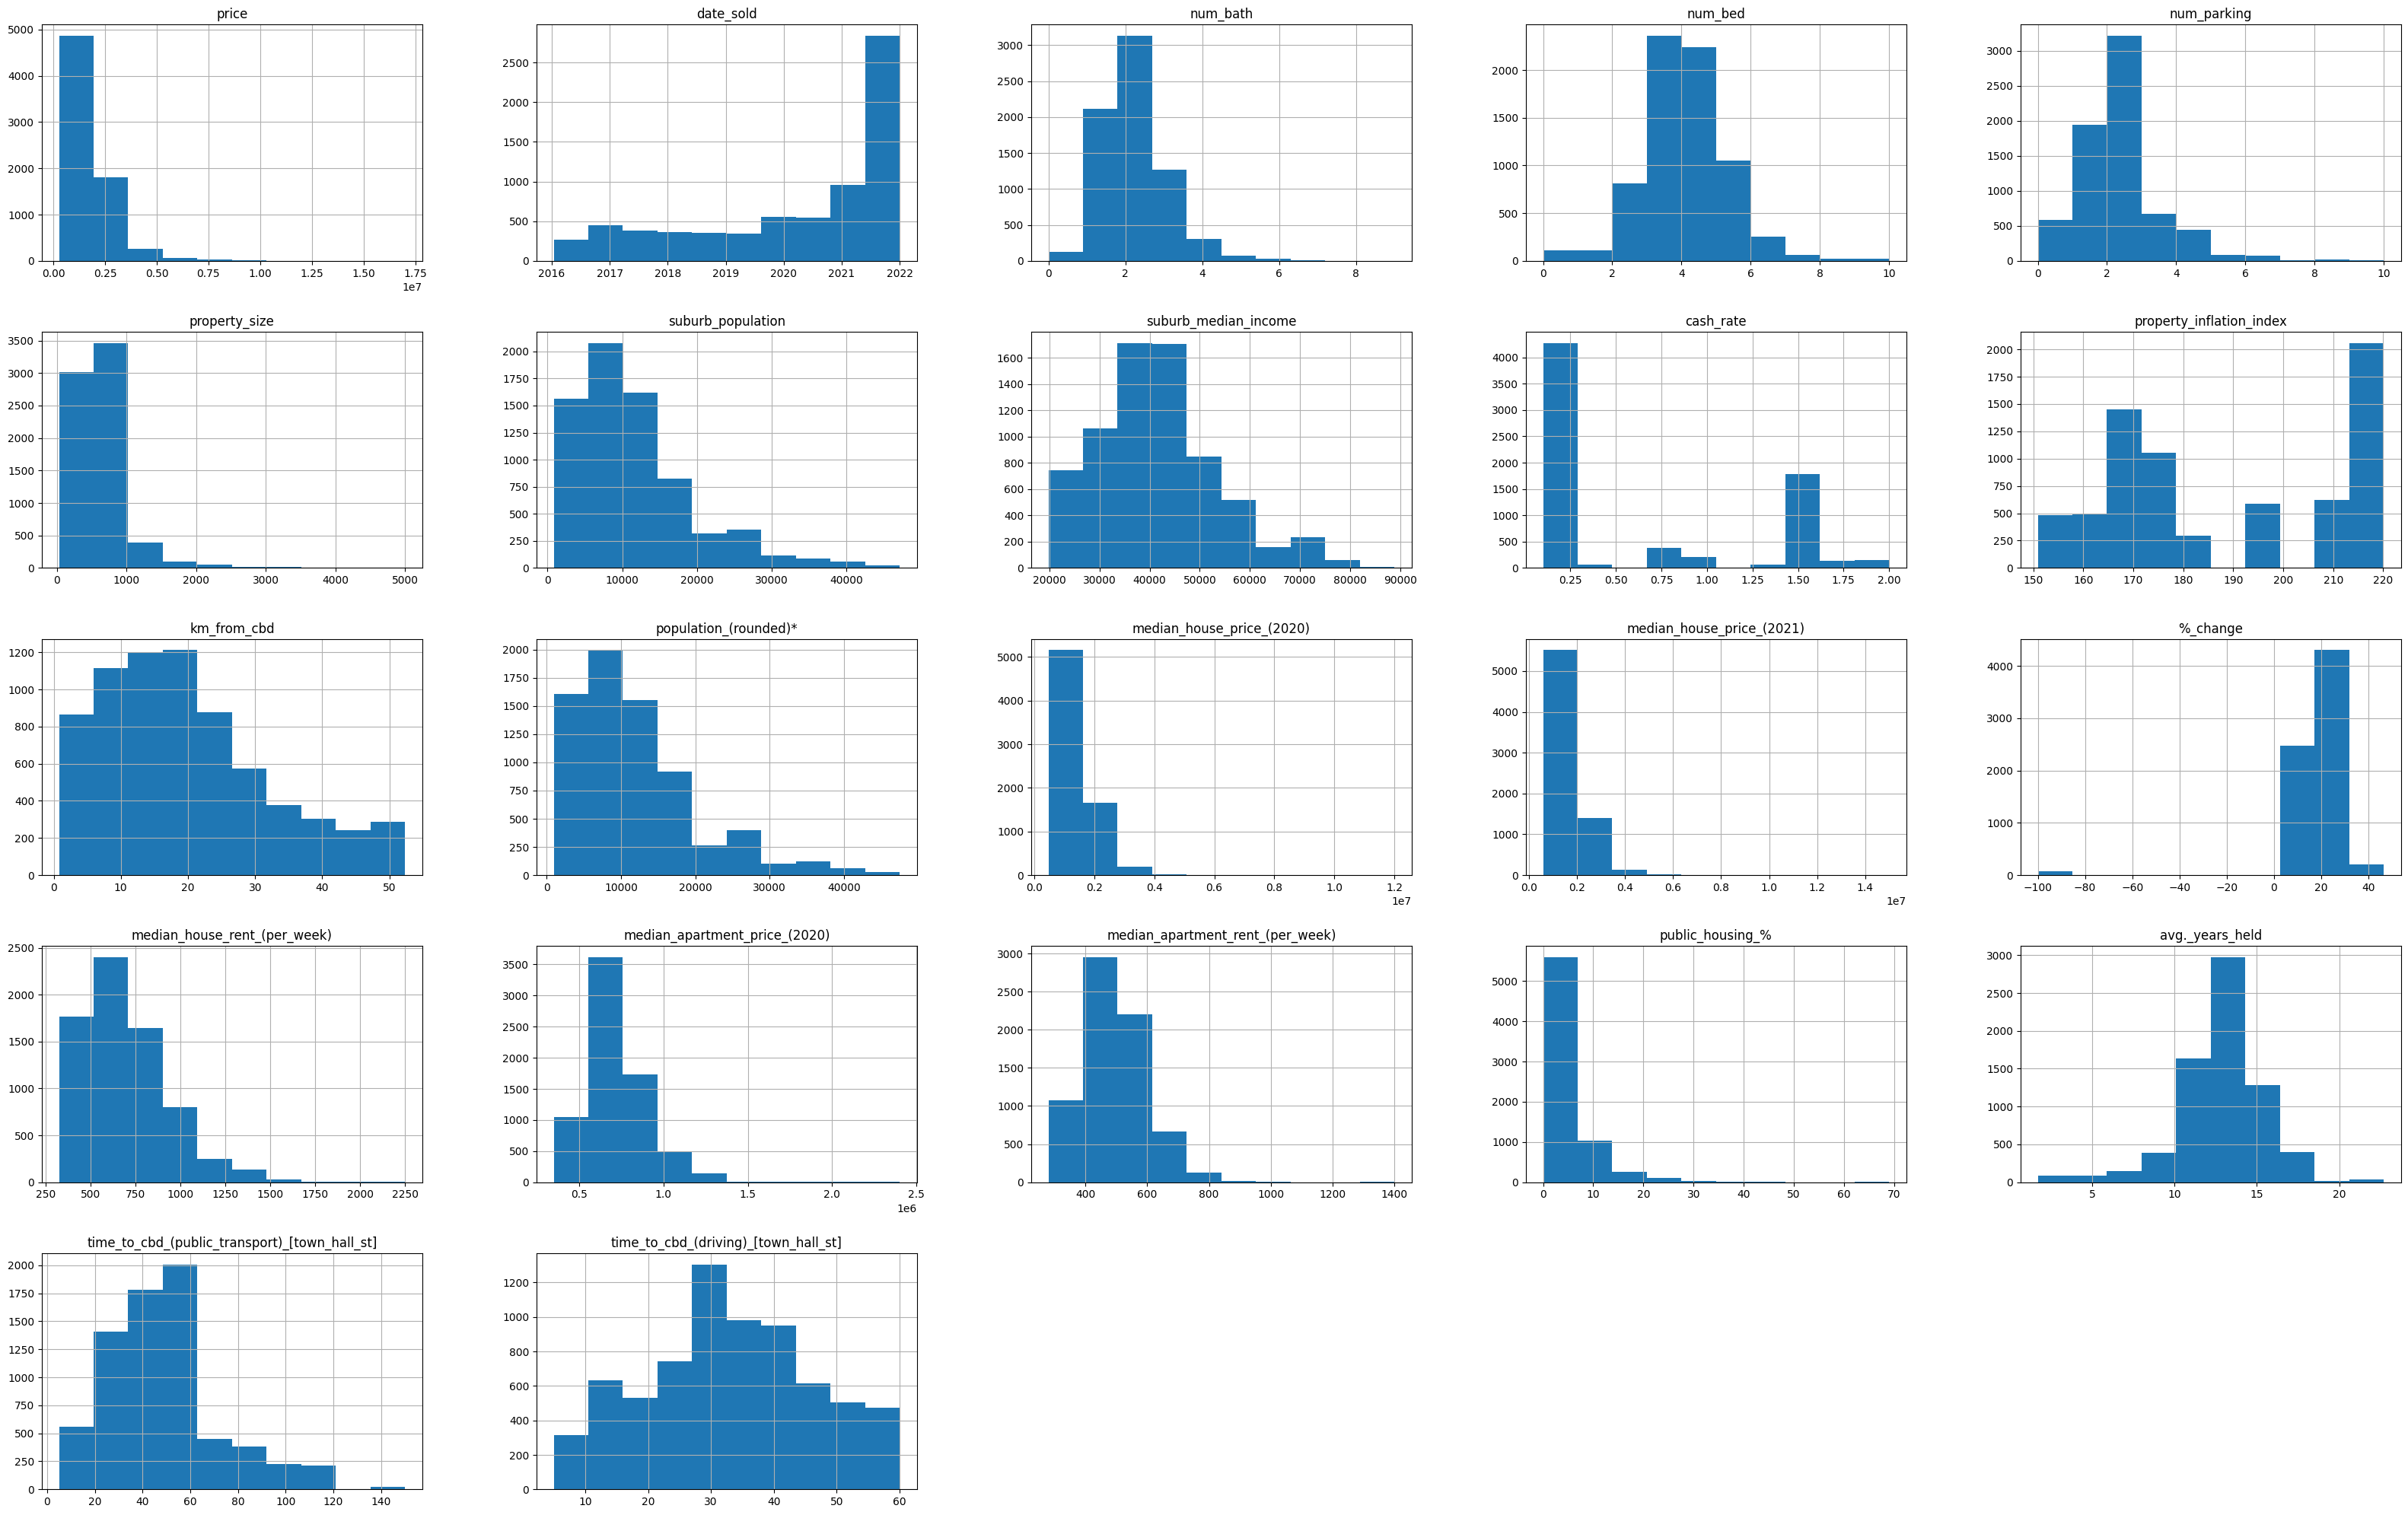

In [60]:
# UNIVARIATE ANALYSIS
merged.hist(figsize=(40,25))

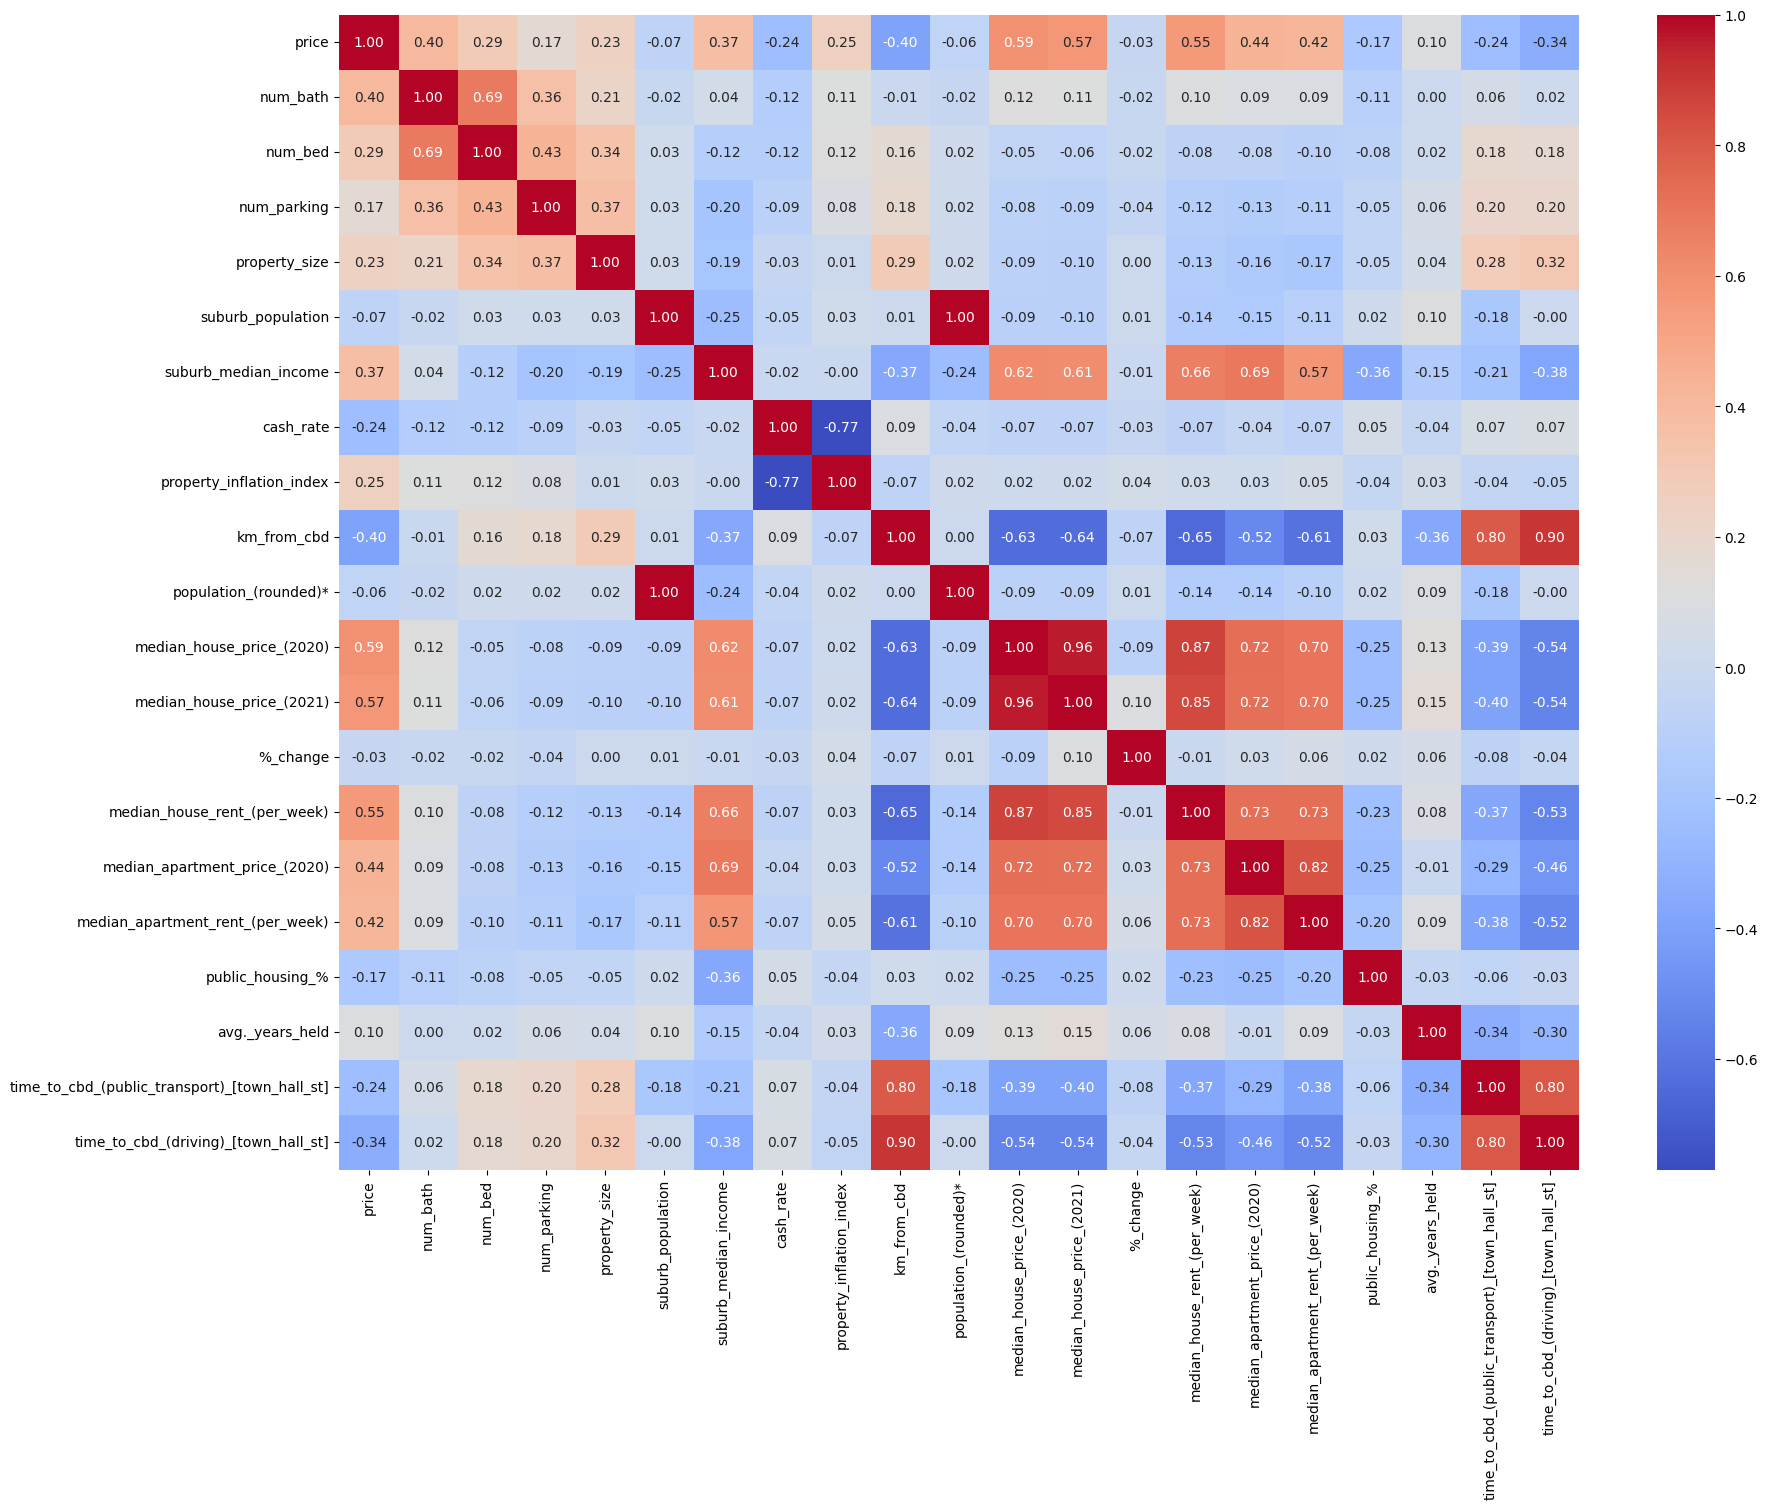

In [61]:
plt.figure(figsize=(20,15))
sns.heatmap(merged.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [62]:
# FILTERING CORR VALUES
corr_matrix = merged.corr(numeric_only=True)

price_corr = corr_matrix["price"].sort_values(ascending=False)
print(price_corr)



price                                            1.000000
median_house_price_(2020)                        0.594744
median_house_price_(2021)                        0.568255
median_house_rent_(per_week)                     0.551381
median_apartment_price_(2020)                    0.435412
median_apartment_rent_(per_week)                 0.421714
num_bath                                         0.403851
suburb_median_income                             0.370997
num_bed                                          0.292065
property_inflation_index                         0.252542
property_size                                    0.234159
num_parking                                      0.167249
avg._years_held                                  0.097980
%_change                                        -0.030060
population_(rounded)*                           -0.063519
suburb_population                               -0.066852
public_housing_%                                -0.167552
cash_rate     

In [63]:
# DROPPING COLUMNS BASED ON LOW CORR
drop_cols = [
    "avg._years_held",
    "%_change",
    "public_housing_%",
    "cash_rate"
]

merged.drop(columns=drop_cols, inplace=True, errors="ignore")

In [64]:
# CHECKING MULTICOLLINEARITY
high_corr = corr_matrix.abs() >= 0.8
np.fill_diagonal(high_corr.values, False)
high_corr_pairs = high_corr[high_corr].stack().reset_index()
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
print(high_corr_pairs)

                               Feature 1  \
0                      suburb_population   
1                            km_from_cbd   
2                  population_(rounded)*   
3              median_house_price_(2020)   
4              median_house_price_(2020)   
5              median_house_price_(2021)   
6              median_house_price_(2021)   
7           median_house_rent_(per_week)   
8           median_house_rent_(per_week)   
9          median_apartment_price_(2020)   
10      median_apartment_rent_(per_week)   
11  time_to_cbd_(driving)_[town_hall_st]   

                               Feature 2 Correlation  
0                  population_(rounded)*        True  
1   time_to_cbd_(driving)_[town_hall_st]        True  
2                      suburb_population        True  
3              median_house_price_(2021)        True  
4           median_house_rent_(per_week)        True  
5              median_house_price_(2020)        True  
6           median_house_rent_(per_week)  

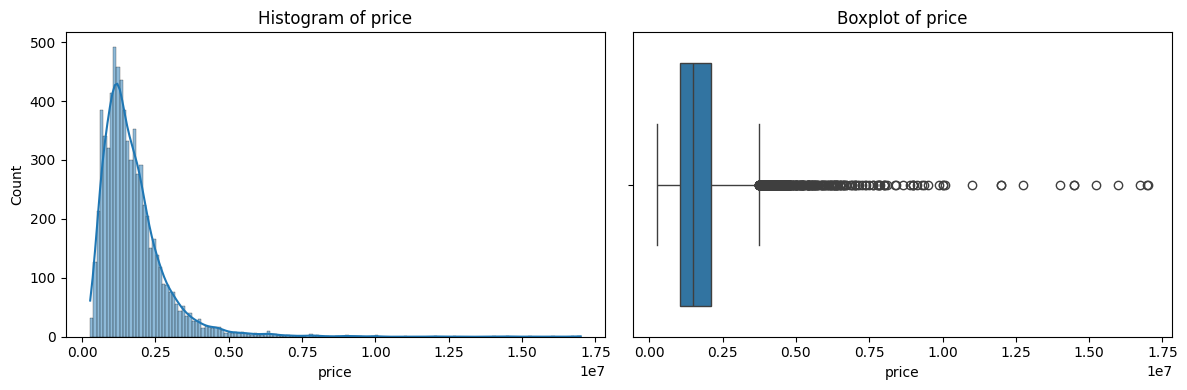

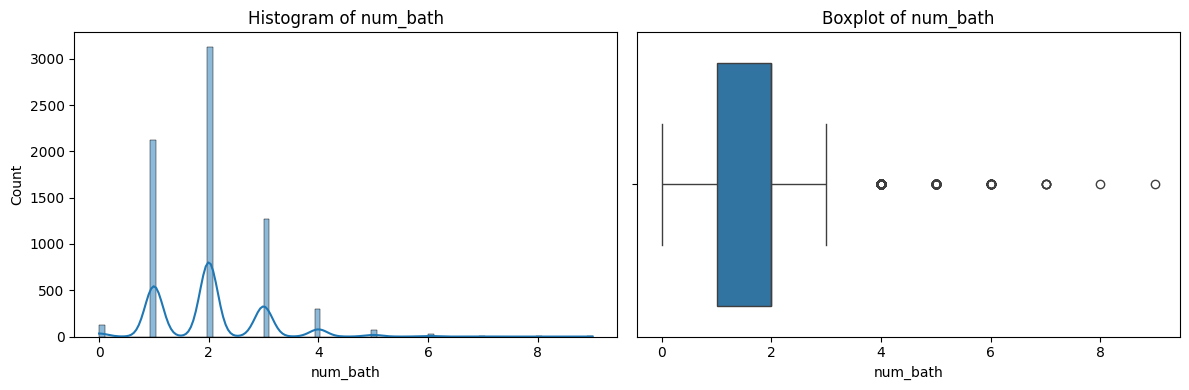

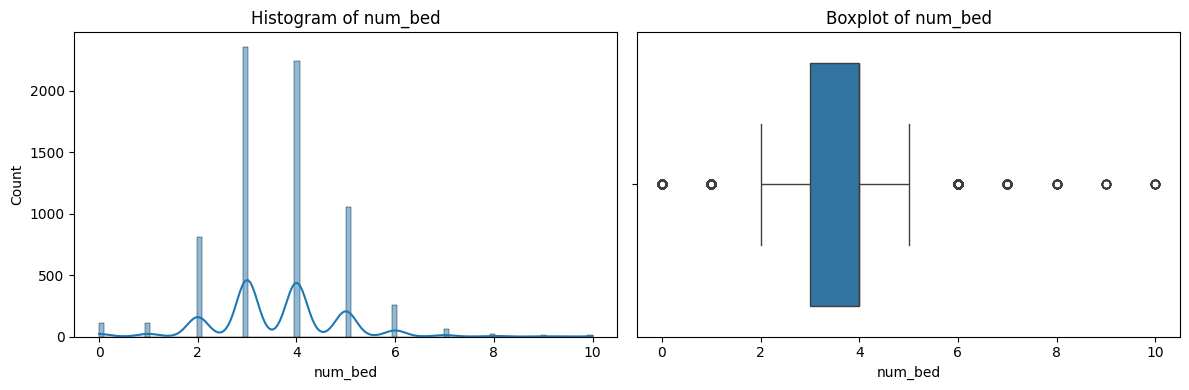

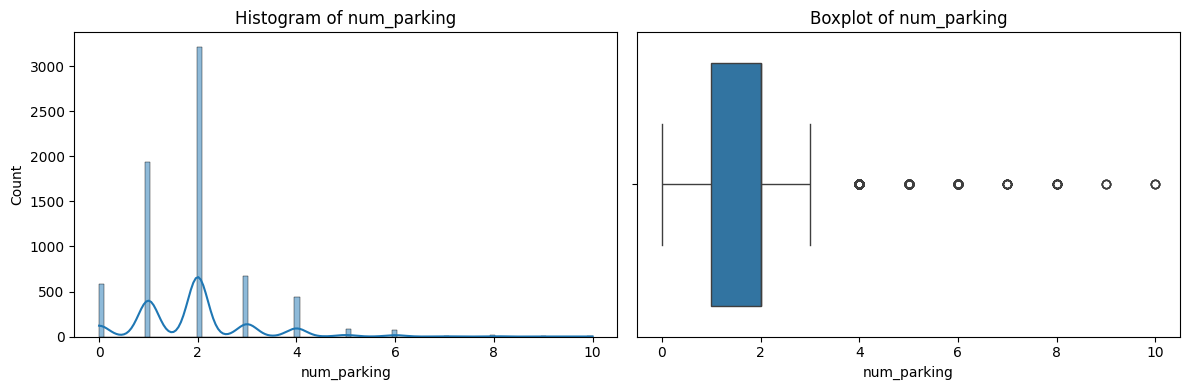

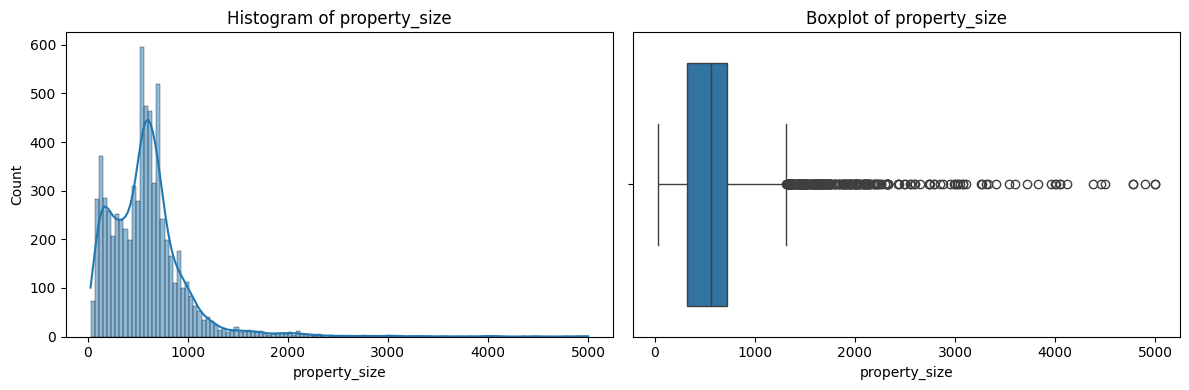

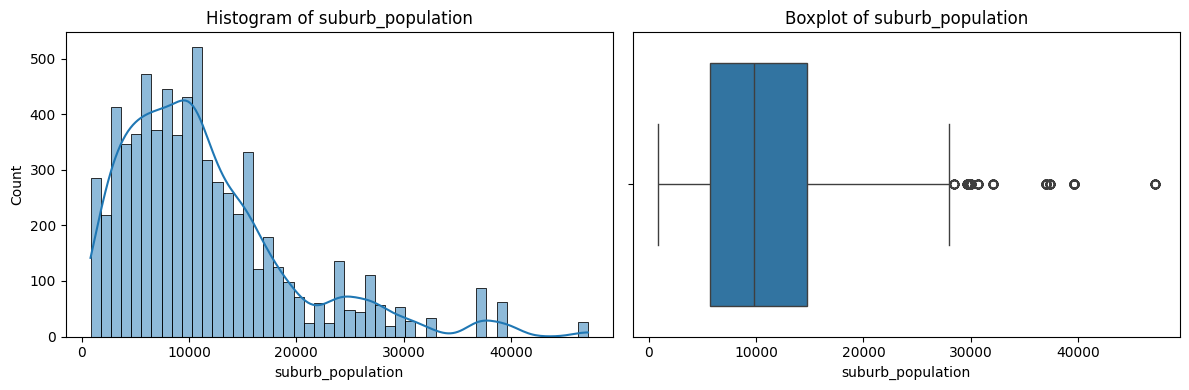

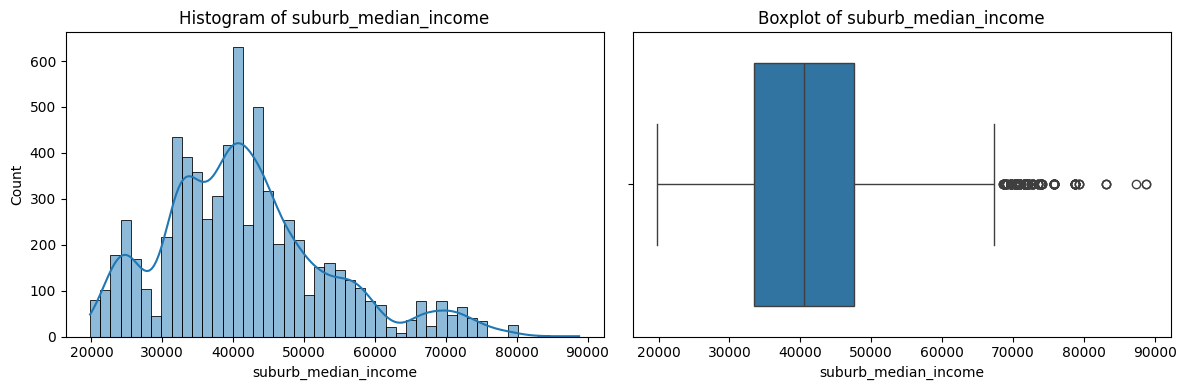

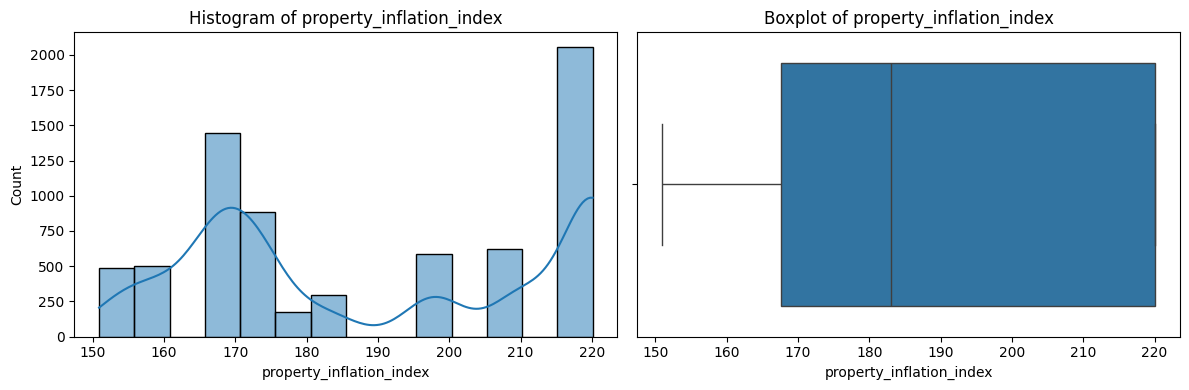

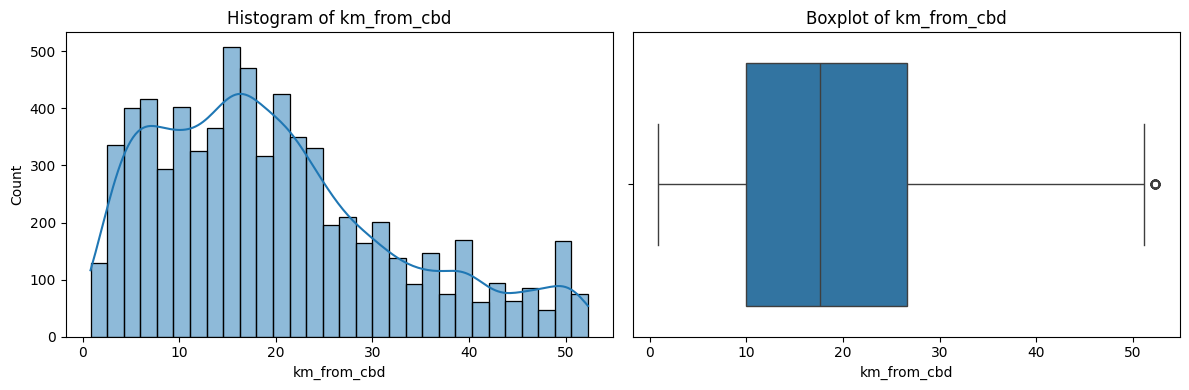

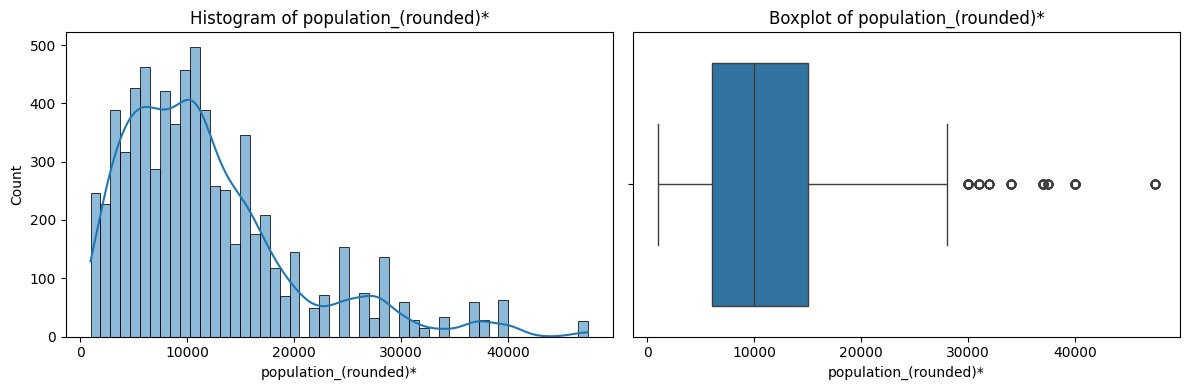

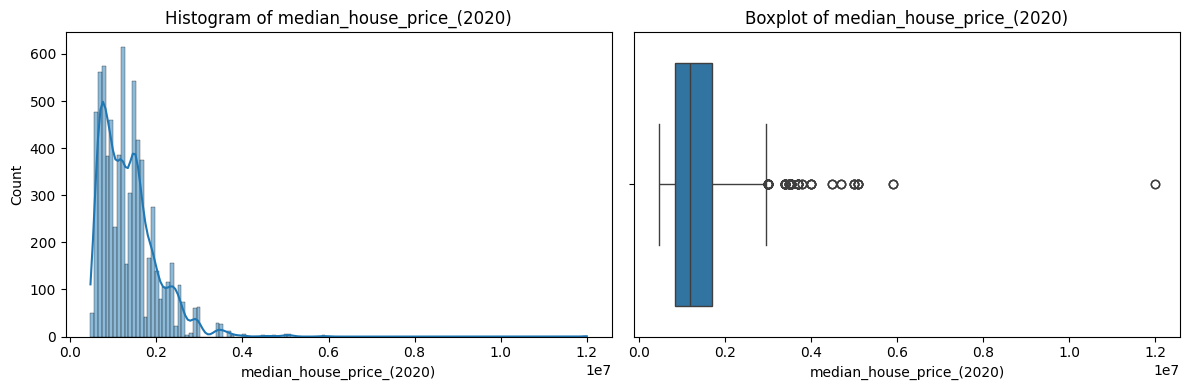

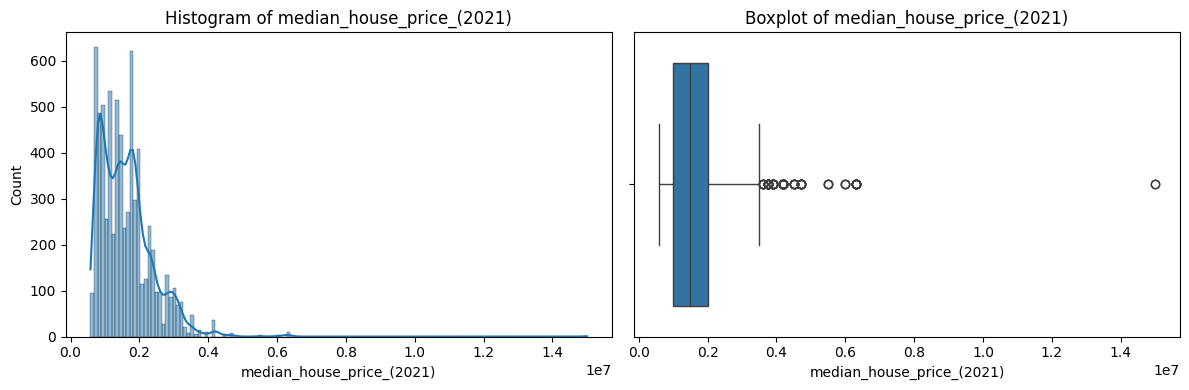

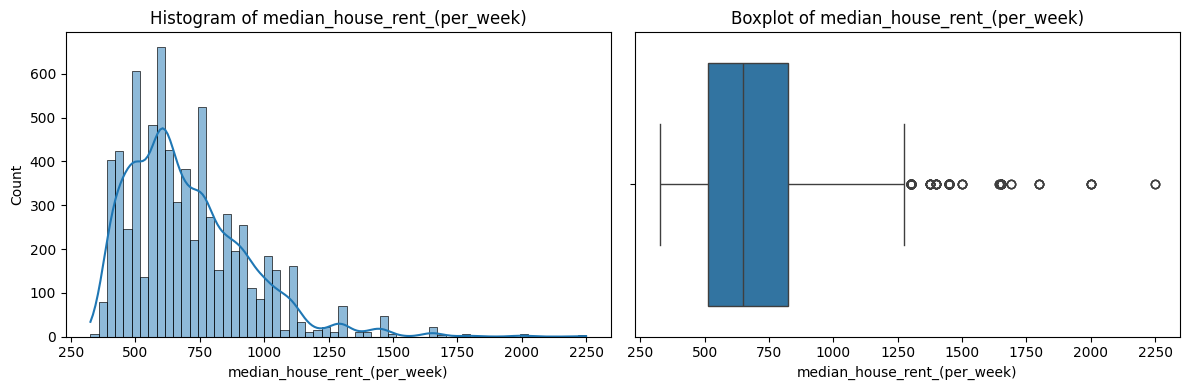

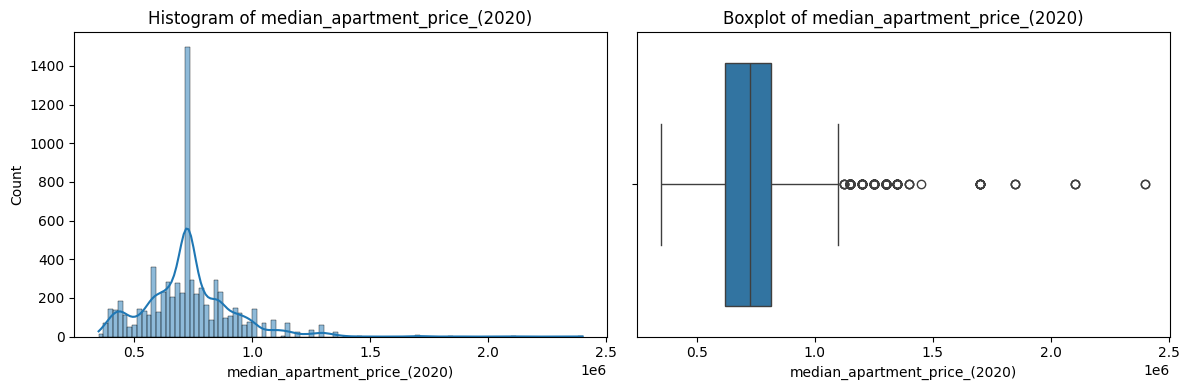

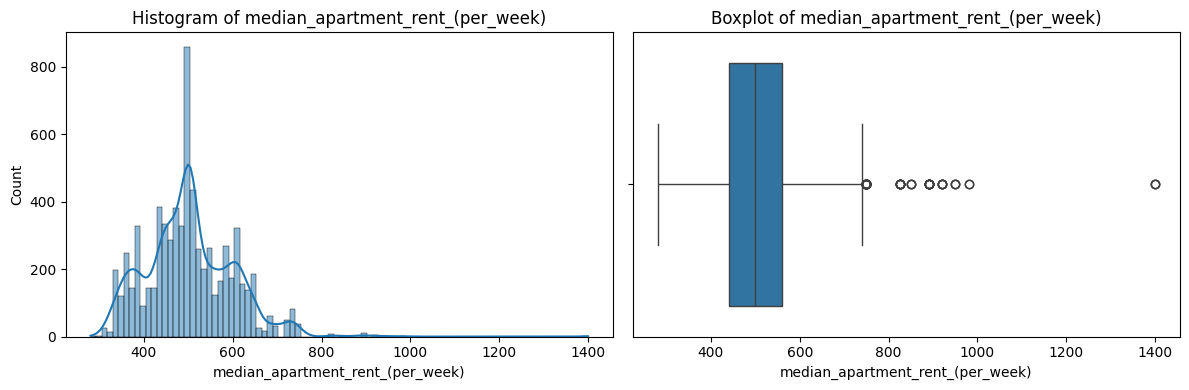

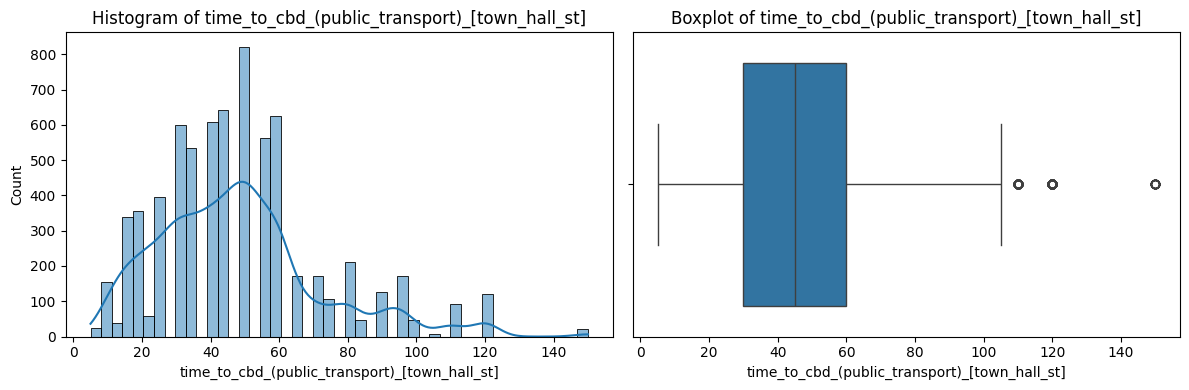

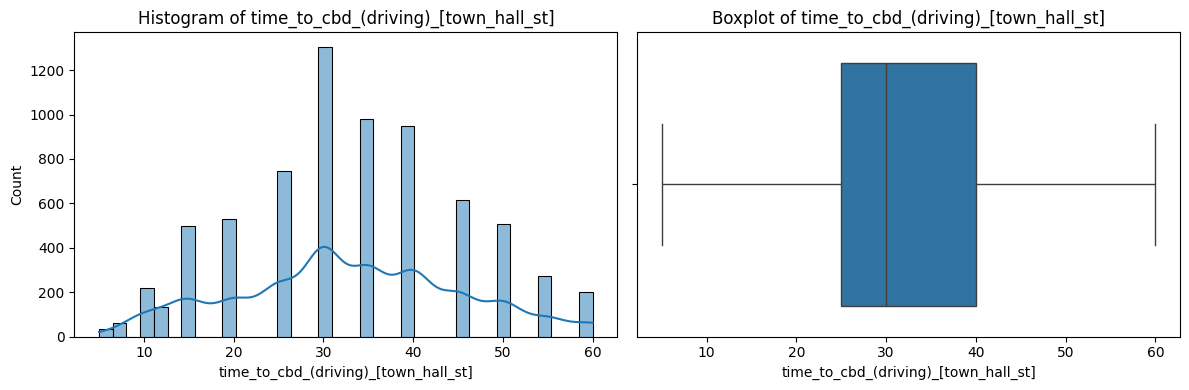

In [65]:
numerical_cols = merged.select_dtypes(include=["int64", "float64"]).columns

for col in numerical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(merged[col], kde=True, ax=axes[0])
    axes[0].set_title(f'Histogram of {col}')
    sns.boxplot(x=merged[col], ax=axes[1])
    axes[1].set_title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()